# Preparation 

In [250]:
import os
import glob
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torchvision
from torchvision import transforms, datasets

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [287]:
train_data = datasets.ImageFolder(os.path.normpath('/home/md359230/DeepLearning/assignment1/data/fruits-360/Training'),
                                  transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=4)

In [288]:
test_data = datasets.ImageFolder(os.path.normpath('/home/md359230/DeepLearning/assignment1/data/fruits-360/Test'),
                                  transform=transform)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 100, 100])


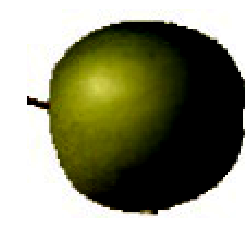

In [215]:
def fruitImShow(img):
    npimg = img.numpy()
    img = plt.imshow(npimg)
    plt.axis('off')
    plt.show()

for i, images in enumerate(train_loader):
    if i >= 0:
        print(images[0].squeeze().size())
        fruitImShow(np.transpose(images[0][0,:,:,:], [1, 2, 0]))
        break

In [216]:
example, no = next(iter(train_loader))

In [217]:
example.size()

torch.Size([128, 3, 100, 100])

In [218]:
tmp = example
print(tmp.size())
tmp = nn.Conv2d(3, 8, 5)(tmp)
print(tmp.size())
tmp = nn.MaxPool2d((2,2))(tmp)
print(tmp.size())
tmp = nn.Conv2d(8, 16, 11)(tmp)
print(tmp.size())
print(tmp.view(4,-1, 16 * 38 * 38).size())
tmp = nn.MaxPool2d(2,2)(tmp)
print(tmp.size())

torch.Size([128, 3, 100, 100])
torch.Size([128, 8, 96, 96])
torch.Size([128, 8, 48, 48])
torch.Size([128, 16, 38, 38])
torch.Size([4, 32, 23104])
torch.Size([128, 16, 19, 19])


In [219]:
linear_layer(16*19*19, 100)

Sequential(
  (0): Linear(in_features=5776, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

# Define Neural Network

In [221]:
! ls -R /home/md359230/DeepLearning/assignment1/data/fruits-360/Training/ | wc -l

49191


In [281]:
! ls -R /home/md359230/DeepLearning/assignment1/data/fruits-360/Test/ | wc -l

16707


In [222]:
49191 / 128

384.3046875

In [223]:
x = torch.randn(2,2,2)
print(x)
print(torch.mean(x, (1,2)))

tensor([[[ 0.8341,  0.1073],
         [-1.5900,  0.7515]],

        [[-0.2715,  0.9093],
         [ 0.0181,  0.0836]]])
tensor([0.0257, 0.1849])


In [224]:
x = torch.randn(2,3, 4, 4)
print(x)

tensor([[[[ 1.3592,  0.9586, -2.2687, -0.7316],
          [-0.1976, -1.3876, -1.7334,  1.0312],
          [-1.3025, -1.4624,  0.6063,  1.0155],
          [-0.9894, -0.8540, -1.0822, -0.0915]],

         [[-0.0558, -0.6707, -2.2107,  0.2486],
          [-0.6671,  1.2670, -0.5990, -0.6199],
          [ 0.3946, -0.4155,  0.6211, -0.0213],
          [ 1.4263,  0.2343, -0.3309, -0.4443]],

         [[-0.3917, -1.1598, -0.9039,  0.5166],
          [ 1.7122, -0.4550, -1.0423, -0.7295],
          [-1.9230, -0.4065,  0.0323,  0.6236],
          [ 0.3059,  1.6485, -0.9048,  0.3842]]],


        [[[-0.0501, -0.1945,  0.5907, -0.1499],
          [-2.2273,  1.7362,  0.4117, -1.0932],
          [ 1.5655, -0.3937, -1.8002,  1.6674],
          [ 0.7181,  0.1063,  0.5773, -0.4593]],

         [[ 0.3989, -1.8571,  2.1592,  1.3154],
          [ 0.8036,  0.7200,  0.6123,  0.7596],
          [ 1.6692, -0.4298,  0.1296, -0.5667],
          [ 1.2675,  0.4753, -0.9747,  0.0288]],

         [[ 1.0556, -2.0220,

In [225]:
class MyBatchNormalization(torch.nn.Module):
    def __init__(self, num_features):
        super(MyBatchNormalization, self).__init__()
        self.num_features = num_features

    def forward(self, x):
        r = x.matmul(self.weight.t())
        r += self.bias
        return r

In [226]:
def batchNorm(x):
    print(x.size())
    means = torch.mean(x, 1, keep_dim=True)
    print(means)

In [227]:
batchNorm(x)

torch.Size([2, 3, 4, 4])


TypeError: mean() received an invalid combination of arguments - got (Tensor, int, keep_dim=bool), but expected one of:
 * (Tensor input)
 * (Tensor input, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, Tensor out)


## Network and trainer

In [391]:
def convolutional_layer(in_channels, 
                        out_channels,
                        kernel_size,
                        batchnorm_module='default', 
                        *args, 
                        **kwargs): 
    """Function for flexible construction of convolutional layers for the network.
    
    :param in_channels: Number of input channels.
    :param out_channels: Number of channels produced by the output.
    :param kernel_size: Kernel size for convolutional layer.
    :param batchnorm_module: Must be in ('default', 'custom'). Should Pytorch's or own BN 
    normalization be used?
    :param *args: Additional arguments to pass to convolutional layer.
    :param **kwargs: Additional arguments to pass to convolutional layer.
    :return: Layer consisting of convolution, batch normalization and max pooling."""
    batchnorm_modules = nn.ModuleDict([
        ['default', nn.BatchNorm2d(out_channels)],
        ['custom', MyBatchNormalization(out_channels)]
    ])
    
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, *args, **kwargs),
        batchnorm_modules[batchnorm_module],
        nn.MaxPool2d((2,2))
    )

In [392]:
def linear_layer(in_features, 
                 out_feautres, 
                 batchnorm_module='default',
                 activation_function='relu', 
                 *args, 
                 **kwargs):
    """Function for flexible construction of full-connected layers for the network.
    
    :param in_features: Size of input layer.
    :param out_features: Size of output layer.
    :param batchnorm_module: Must be in ('default', 'custom'). Should Pytorch's or own BN 
    normalization be used?
    :param activation_fuction: Must be in ('relu', 'lrelu', 'sigmoid'). Which activation
    function should be used?
    :param *args: Additional arguments to pass to full-connected layer.
    :param **kwargs: Additional arguments to pass to full-connected layer.
    :return: Layer consisting of full-connected module, batch normalization and activation function."""
    batchnorm_modules = nn.ModuleDict([
        ['default', nn.BatchNorm1d(out_feautres)],
        ['custom', MyBatchNormalization(out_feautres)]
    ])
    
    activation_functions = nn.ModuleDict([
        ['lrelu', nn.LeakyReLU()],
        ['relu', nn.ReLU()],
        ['sigmoid', nn.Sigmoid()]
    ])

    return nn.Sequential(
        nn.Linear(in_features, out_feautres, *args, **kwargs),
        batchnorm_modules[batchnorm_module],
        activation_functions[activation_function]
    )

In [424]:
class ConvolutionalStack(nn.Module):
    def __init__(self, sizes, kernel_sizes, *args, **kwargs):
        super(ConvolutionalStack, self).__init__()
        self.convolutional_layers = nn.ModuleList([convolutional_layer(in_size, out_size, ker_size, *args, **kwargs)
                                                   for in_size, out_size, ker_size in zip(sizes, sizes[1:], kernel_sizes)])
    def forward(self, x):
        for convolutional_layer in self.convolutional_layers:
            x = convolutional_layer(x)
        return x

In [425]:
class LinearStack(nn.Module):
    def __init__(self, sizes, n_classes, *args, **kwargs):
        super(LinearStack, self).__init__()
        self.linear_layers = nn.ModuleList([linear_layer(in_size, out_size, *args, **kwargs)
                                                   for in_size, out_size in zip(sizes, sizes[1:])])
        self.linear_layers.append(nn.Linear(sizes[-1], n_classes))
        
    def forward(self, x):
        for linear_layer in self.linear_layers:
            x = linear_layer(x)
        return x

In [429]:
class Net(nn.Module):
    def __init__(self, conv_sizes, kernel_sizes, linear_sizes, n_classes):
        super(Net, self).__init__()
        self.conv = ConvolutionalStack(conv_sizes, kernel_sizes)
        self.fc = LinearStack(linear_sizes, n_classes)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16 * 19 * 19)
        x = self.fc(x)
        x = x.squeeze()
        return x

In [430]:
class FruitTrainer(object):
    def __init__(self, train_data, train_loader, test_data, test_loader):
        self.trainset = train_data
        self.trainloader = train_loader
        
        self.testset = test_data
        self.testloader = test_loader
        
    def assess(self, net, test=True):
        correct = 0
        total = 0
        if test:
            for data in self.testloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the {} test images: {:2.4f} %'.format(
                total, 100 * correct / total))
        else:
            for data in self.trainloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the {} train images: {:2.4f} %'.format(
                total, 100 * correct / total))            
                       
    def train(self):
        net = Net((3, 8, 16), (5, 11), (16 * 19 * 19, 1000, 500), 95)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)

        for epoch in range(4):
            running_loss = 0.0
            t = time.time()
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % 100 == 99:
                    print('[%d, %5d] loss: %.4f' %
                          (epoch + 1, i + 1, running_loss / 100))
                    print('[%d, %5d] Elapsed time: %2.4f s' %
                          (epoch + 1, i + 1, time.time() - t))
                    running_loss = 0.0
                    t = time.time()
            
            self.assess(net)
            self.assess(net, test=False)


In [432]:
trainer = FruitTrainer(train_data, train_loader, test_data, test_loader)
trainer.train()

[1,   100] loss: 1.6463
[1,   100] Elapsed time: 34.4545 s
[1,   200] loss: 0.1690
[1,   200] Elapsed time: 35.1712 s
[1,   300] loss: 0.0370
[1,   300] Elapsed time: 34.6791 s
Accuracy of the network on the 16445 test images: 96.9839 %
Accuracy of the network on the 48905 train images: 99.9652 %
[2,   100] loss: 0.0121
[2,   100] Elapsed time: 34.3910 s
[2,   200] loss: 0.0080
[2,   200] Elapsed time: 35.6789 s
[2,   300] loss: 0.0085
[2,   300] Elapsed time: 34.0123 s
Accuracy of the network on the 16445 test images: 95.8589 %
Accuracy of the network on the 48905 train images: 99.6156 %
[3,   100] loss: 0.0124
[3,   100] Elapsed time: 33.1980 s
[3,   200] loss: 0.0069
[3,   200] Elapsed time: 29.0671 s
[3,   300] loss: 0.0036
[3,   300] Elapsed time: 32.0296 s
Accuracy of the network on the 16445 test images: 97.1846 %
Accuracy of the network on the 48905 train images: 100.0000 %


In [390]:
a = (1,2,3,4)
b = (-1,-2,-3)
list(zip(a, a[1:], b))

[(1, 2, -1), (2, 3, -2), (3, 4, -3)]

In [310]:
a[:-1]

(1, 2, 3)